# Assignment 1: Text Classification with Logistic Regression


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
# load the training, development and test sets
train_data = pd.read_csv('data_sentiment/train.csv',header=None, names=['text','label'])
dev_data = pd.read_csv('data_sentiment/dev.csv',header=None, names=['text','label'])
test_data = pd.read_csv('data_sentiment/test.csv',header=None, names=['text','label'])

If you use Pandas you can see a sample of the data.

In [3]:
train_data.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [4]:
type(train_data)

pandas.core.frame.DataFrame

The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [5]:
# put the raw texts into Python lists
train_text = train_data['text'].tolist()
dev_text = dev_data['text'].tolist()
test_text = test_data['text'].tolist()

# put their corresponding labels into NumPy arrays
train_label = np.array(train_data['label'])
dev_label = np.array(dev_data['label'])
test_label = np.array(test_data['label'])


# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [6]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- `x` : a list of all extracted features.(Remove the same ngram)
- `text_ngrams` : a list of all extracted features.(split for several list by different rows of `x_raw`（Two-dimensional）)

See the examples below to see how this function should work.

In [7]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):    
    #create list x
    x = []
    #create list text_ngrams(store all extracted ngrams of documents)
    text_ngrams = []
    #extract texts according to different documents
    for raw in x_raw:
        #create list n_g_list(store a document of the extracted ngrams)  
        n_g_list = []
        # use stop_words to delete these words in document
        train_token = re.findall(token_pattern,raw)
        train_stop = []
        for raw_token in train_token:
            if raw_token not in stop_words:
                train_stop.append(raw_token)
        #use n_g_list list to save the extracted ngrams of a document.
        for i in range(min(ngram_range),max(ngram_range)+1):
            length = len(train_stop)-i+1
            for j in range(length):
                if i ==1:
                    unigram = train_stop[j]
                    x.append(unigram)
                    n_g_list.append(unigram)
                else:
                    ngrams = tuple(train_stop[j:j+i])
                    x.append(ngrams)
                    n_g_list.append(ngrams)
        text_ngrams.append(n_g_list)
    x = set(x)
    
    return x, text_ngrams




In [8]:
# Get the list of all extracted features for train set
tr_x, tr_text_ngrams = extract_ngrams(x_raw = train_text, stop_words=stop_words)

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=5000, stop_words=[]):
    
    x, ngrams_list = extract_ngrams(x_raw=X_raw, stop_words=stop_words)
    
    df = {}    
    # use dict(df) to save all ngrams as keys and their corresponding document frequency as values               
    for grams in ngrams_list:
        grams_uni = set(grams)
        for n_gram in grams_uni:
            if n_gram not in df.keys():
                df[n_gram]=1
            else:
                df[n_gram]+=1

    #order by the dict.values              
    df = dict(sorted(df.items(), key=lambda x:x[1], reverse=True))
    #keep top-N more frequent ngrams
    df = {k: df[k] for k in list(df.keys())[:keep_topN]}
 
    vocab= [ i for i in df.keys()]
    ngram_counts= [ i for i in df.values()]
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
#according to train set to got my vocabulary as feature
vocab, tr_df, tr_ngram_counts = get_vocab(X_raw=train_text, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [12]:
# create word dictionaries 
vocab_dict = {}
for i in range(len(vocab)):
    vocab_dict[i] = vocab[i]

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [13]:
dev_x, dev_text_ngrams = extract_ngrams(x_raw = dev_text, stop_words=stop_words)
test_x, test_text_ngrams = extract_ngrams(x_raw = test_text, stop_words=stop_words)

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [14]:
def vectorise(X_ngram, vocab):
    #Create a two-dimensional array（initialize all zero）, the number of rows is the number of documents, the number of columns is the number of features
    X_vec = np.zeros((len(X_ngram),len(vocab)))
    for i, text in enumerate(X_ngram):
        for j, word in enumerate(vocab):
            #count the number of words of vocab appearing in the document.
            count = text.count(word)
            X_vec[i][j]=count
                
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [15]:
# obtain document vectors for each document in the train, development and test set
X_tr_count = vectorise(X_ngram=tr_text_ngrams, vocab=vocab)
X_dev_count = vectorise(X_ngram=dev_text_ngrams, vocab=vocab)
X_test_count = vectorise(X_ngram=test_text_ngrams, vocab=vocab)

In [16]:
X_tr_count

array([[ 6.,  8., 20., ...,  0.,  1.,  1.],
       [ 2.,  5.,  6., ...,  0.,  0.,  0.],
       [ 5.,  4.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  2.,  4., ...,  0.,  0.,  0.],
       [11.,  7., 11., ...,  0.,  0.,  0.],
       [ 2.,  3.,  8., ...,  0.,  0.,  0.]])

In [17]:
X_tr_count.shape

(1400, 5000)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

Then transform your count vectors to tf.idf vectors:

In [18]:
# create idf vocabulary dictiongnary for training data
vocab_idfs_tr={}
for word in vocab:
    doc_count=0
    for text in tr_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_tr[word]=np.log((len(tr_text_ngrams)/doc_count))

In [19]:
# create idf vocabulary dictiongnary for development data
vocab_idfs_dev={}
for word in vocab:
    doc_count=0
    for text in dev_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_dev[word]=np.log((len(dev_text_ngrams)+1) / (doc_count+1))

In [20]:
# create idf vocabulary dictiongnary for test data
vocab_idfs_test={}
for word in vocab:
    doc_count=0
    for text in test_text_ngrams:
        if word in text:
            doc_count+=1
    vocab_idfs_test[word]=np.log((len(test_text_ngrams)+1) / (doc_count+1))

In [21]:
# For training set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_tr.keys()):
    # get the i column feature value
    value = X_tr_count[:,i]
    # tf * idf
    tfidf = value * vocab_idfs_tr[word]
    tfidf_mat.append(tfidf)

X_tr_tfidf = np.asarray(tfidf_mat)
X_tr_tfidf = np.transpose(X_tr_tfidf)

In [22]:
# For development set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_dev.keys()):
    value = X_dev_count[:,i]
    tfidf = value * vocab_idfs_dev[word]
    tfidf_mat.append(tfidf)

X_dev_tfidf = np.asarray(tfidf_mat)
X_dev_tfidf = np.transpose(X_dev_tfidf)

In [23]:
# For test set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_test.keys()):
    value = X_test_count[:,i]
    tfidf = value * vocab_idfs_test[word]
    tfidf_mat.append(tfidf)

X_test_tfidf = np.asarray(tfidf_mat)
X_test_tfidf = np.transpose(X_test_tfidf)

In [24]:
X_tr_tfidf.shape

(1400, 5000)

In [26]:
X_tr_tfidf

array([[0.28974173, 0.92585256, 2.57290779, ..., 0.        , 4.41101417,
        4.41101417],
       [0.09658058, 0.57865785, 0.77187234, ..., 0.        , 0.        ,
        0.        ],
       [0.24145145, 0.46292628, 1.02916312, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.14487087, 0.23146314, 0.51458156, ..., 0.        , 0.        ,
        0.        ],
       [0.53119318, 0.81012099, 1.41509928, ..., 0.        , 0.        ,
        0.        ],
       [0.09658058, 0.34719471, 1.02916312, ..., 0.        , 0.        ,
        0.        ]])

In [27]:
X_tr_tfidf[1,:50]

array([0.09658058, 0.57865785, 0.77187234, 0.35893698, 0.90330287,
       0.        , 0.51902239, 0.87162991, 0.58299774, 0.88311318,
       0.89175457, 1.26667844, 0.65304381, 0.        , 0.74419883,
       0.79882407, 0.        , 0.        , 0.83970769, 1.28576258,
       0.        , 0.        , 0.94229428, 0.99563077, 0.50489089,
       0.52884413, 0.55711891, 2.86730597, 0.590075  , 0.59394847,
       0.60043778, 1.20348143, 0.        , 2.45417652, 0.61750977,
       0.62149119, 0.        , 0.        , 3.16765735, 0.68178342,
       1.3663937 , 0.        , 0.        , 0.70608769, 0.        ,
       2.17524068, 0.74444047, 0.74594537, 1.51004517, 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [28]:
def sigmoid(z):
    
    sig = 1. / (1 + np.exp(-z))
    
    return sig




In [29]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [30]:
def predict_proba(X, weights):
    
    dot_p = np.dot(X,weights)
    preds_proba = sigmoid(dot_p)
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [31]:
def predict_class(X, weights):
    
    proba = predict_proba(X = X, weights = weights)
    # if the probability of the class less than 0.5, then the label for this class is 0, otherwise, 1.
    proba[proba<0.5]=0
    proba[proba>=0.5]=1
    preds_class = proba.astype(np.int64)
       
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [32]:
def binary_loss(X, Y, weights, alpha=0.00001):
    
    
    y_pred = predict_proba(X = X, weights = weights)
    # Clip y_pred between alpha and 1-alpha
    y_pred = np.clip(y_pred, alpha, 1-alpha)
    loss = - Y * np.log(y_pred) - (1 - Y) * np.log(1-y_pred)
    L2_regularization = (alpha/2)*(np.sum(np.square(weights)))
    # Use L2 regularisation
    l = loss + L2_regularization

    return l


Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [49]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=100, tolerance=0.0001, print_progress=True):
    
    pre_loss_dev = 10.
    training_loss_history = []
    validation_loss_history = []
    
    weights = np.zeros(X_tr.shape[1])
    
    #Perform multiple epochs over the training data 
    for i in range(epochs):
        #Randomise the order of training data after each epoch
        np.random.seed(i)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(i)
        new_Y_tr = np.random.permutation(Y_tr)
        # The list store training loss for each document.
        tr_loss_list = []
        for j, X_tr_row in enumerate(new_X_tr):
            tr_loss = binary_loss(X = X_tr_row, Y=new_Y_tr[j], weights = weights, alpha=alpha)
            tr_loss_list.append(tr_loss)
            y_pred = predict_proba(X = X_tr_row, weights = weights)
            error = y_pred-new_Y_tr[j]
            weights = weights - lr*error*X_tr_row
        #get average training loss
        aver_tr_loss = np.mean(tr_loss_list)
        training_loss_history.append(aver_tr_loss)
        #compute validation set loss
        valid_loss = binary_loss(X = X_dev, Y=Y_dev, weights = weights, alpha=alpha)
        valid_loss = sum(valid_loss)/len(valid_loss)
        validation_loss_history.append(valid_loss)
        
        #After each epoch print the training and development loss
        print('Epoch: %d' % i, '| Training loss: %f' % aver_tr_loss, '| Validation loss: %f' % valid_loss)
        
        #Stop training if the difference between the current and previous validation loss is smaller than tolerance
        if (pre_loss_dev-valid_loss)<tolerance:
            break
        pre_loss_dev = valid_loss

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [34]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count, Y_tr = train_label, 
                                             X_dev=X_dev_count, 
                                             Y_dev=dev_label, 
                                             lr=0.0001,
                                             alpha=0.0001, 
                                             epochs=100)

Epoch: 0 | Training loss: 0.667093 | Validation loss: 0.648187
Epoch: 1 | Training loss: 0.613701 | Validation loss: 0.620114
Epoch: 2 | Training loss: 0.575545 | Validation loss: 0.597205
Epoch: 3 | Training loss: 0.545176 | Validation loss: 0.575124
Epoch: 4 | Training loss: 0.520335 | Validation loss: 0.562594
Epoch: 5 | Training loss: 0.499663 | Validation loss: 0.549006
Epoch: 6 | Training loss: 0.481563 | Validation loss: 0.537931
Epoch: 7 | Training loss: 0.465454 | Validation loss: 0.529435
Epoch: 8 | Training loss: 0.451275 | Validation loss: 0.520830
Epoch: 9 | Training loss: 0.438504 | Validation loss: 0.513939
Epoch: 10 | Training loss: 0.426575 | Validation loss: 0.505659
Epoch: 11 | Training loss: 0.415875 | Validation loss: 0.501853
Epoch: 12 | Training loss: 0.406412 | Validation loss: 0.494416
Epoch: 13 | Training loss: 0.397229 | Validation loss: 0.489247
Epoch: 14 | Training loss: 0.388496 | Validation loss: 0.483964
Epoch: 15 | Training loss: 0.380787 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

#### Answer:
The model is overfit, because the final loss function value of the training data is much lower than that of the validation data.
The reason for this result is over-training the training set data, resulting in local optimization, and the model's generalization ability is not good, so the error rate of the verification set is higher than the training set.

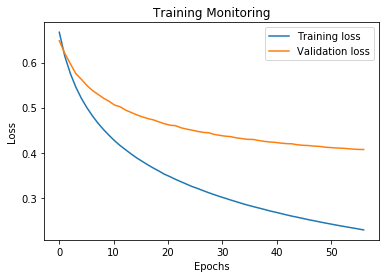

In [35]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Compute accuracy, precision, recall and F1-scores:

In [36]:
def accuracy_score(Y_te,preds_te_count):
    
    count = 0
    for i,label in enumerate(Y_te):
        # when the prediction（preds_te_count） and the real label （Y_te）are the same
        if preds_te_count[i] == label:
            count = count+1
            
    return count/len(Y_te)

In [37]:
def precision_score(Y_te,preds_te_count):
    #The numerator is the number of the case where the prediction（preds_te_count） and the real label （Y_te）are both with 1.
    num = ((Y_te==1)*(preds_te_count==1)).sum()
    # The denominator is the number of the predic tion label is 1.
    deno = (preds_te_count==1).sum()
    return num/deno

def recall_score(Y_te, preds_te_count):
    num = ((Y_te==1)*(preds_te_count==1)).sum()
    # The denominator is the number of the actual label is 1.
    deno = (Y_te==1).sum()
    return num/deno

def f1_score(Y_te, preds_te_count):
    num = 2 * precision_score(Y_te, preds_te_count) * recall_score(Y_te, preds_te_count)
    deno = (precision_score(Y_te, preds_te_count) + recall_score(Y_te, preds_te_count))
    return num/deno

In [38]:
p_class_count = predict_class(X = X_test_count, weights = w_count)
Y_te = test_label
preds_te_count = p_class_count

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8325
Precision: 0.8275862068965517
Recall: 0.84
F1-Score: 0.8337468982630273


Finally, print the top-10 words for the negative and positive class respectively.

In [39]:
dic_count = {}
for i,weight in enumerate(w_count):
    dic_count[vocab[i]] = weight

# get positive words
dic_count_p = {k:v for k, v in dic_count.items() if v>=0}
#order by weights
dic_count_p= dict(sorted(dic_count_p.items(), key=lambda x:x[1], reverse=True))
# select top 10 words
dic_count_p = {k: dic_count_p[k] for k in list(dic_count_p.keys())[:10]}

# get negative words
dic_count_n = {k:v for k, v in dic_count.items() if v<0}
#order by weights
dic_count_n= dict(sorted(dic_count_n.items(), key=lambda x:x[1], reverse=False))
# select top 10 words
dic_count_n = {k: dic_count_n[k] for k in list(dic_count_n.keys())[:10]}

print("The top 10 positive words are %s respectively."% list(dic_count_p.keys()))
print("The top 10 negative words are %s respectively."% list(dic_count_n.keys()))


The top 10 positive words are ['great', 'well', 'also', 'life', 'seen', 'world', 'many', 'fun', 'movies', 'see'] respectively.
The top 10 negative words are ['bad', 'only', 'worst', 'plot', 'unfortunately', 'script', 'why', 'any', 'boring', 'nothing'] respectively.


Some of the obtained top10 words above have no meaning, such as also, many, any and so on.

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

#### Answer:
We could use the classifier into a different domain such laptop reviews or restaurant reviews, because there are many adjectives and adverbs that can indicate positive or negative categories, such as 'great' and 'well' for positive features, 'bad', 'worst', 'unfortunately', etc. for negative features, these features would generalise well, so it's suitable in new fields. But there are still some of words doesn't make sense, such as  'also', 'many', etc., it's bug.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)?

In [41]:
# choose model hyperparameters: learning rate and regularisation strength
lr_hyper = [0.001,0.0001,0.00001]
alpha_hyper = [0.01,0.001,0.0001]

for lr in range(len(lr_hyper)):
    for alpha in range(len(alpha_hyper)):
        w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count, Y_tr = train_label, 
                                             X_dev=X_dev_count, 
                                             Y_dev=dev_label, 
                                             lr=lr_hyper[lr],
                                             alpha=alpha_hyper[alpha], 
                                             epochs=100)
        preds = predict_class(X = X_test_count, weights = w_count)
        # If test this, we need change `SGD` to comment out that print(add # in front of print, do not print loss), 
        #then we can just see the results of F1-Score for several hyperparameters.
        print('When lr = %f, alpha = %f; '%(lr_hyper[lr],alpha_hyper[alpha]), 'F1-Score:', f1_score(Y_te = test_label, preds_te_count = preds))
        

When lr = 0.001000, alpha = 0.010000;  F1-Score: 0.8286445012787724
When lr = 0.001000, alpha = 0.001000;  F1-Score: 0.8286445012787724
When lr = 0.001000, alpha = 0.000100;  F1-Score: 0.8286445012787724
When lr = 0.000100, alpha = 0.010000;  F1-Score: 0.8320802005012531
When lr = 0.000100, alpha = 0.001000;  F1-Score: 0.8337468982630273
When lr = 0.000100, alpha = 0.000100;  F1-Score: 0.8337468982630273
When lr = 0.000010, alpha = 0.010000;  F1-Score: 0.8148148148148149
When lr = 0.000010, alpha = 0.001000;  F1-Score: 0.8148148148148149
When lr = 0.000010, alpha = 0.000100;  F1-Score: 0.8148148148148149


From the above results, we can see that when lr = 0.0001 and alpha = 0.001(also 0.0001), the F1-Score value reaches the maximum, 0.8337. As lr continues to increase, the F1-Score value becomes smaller. 

In general, the learning rate(lr) has a greater impact on model training, while regularisation strength(alpha) has little effect.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [43]:
w_tfidf, trl, devl = SGD(X_tr = X_tr_tfidf, Y_tr = train_label, 
                         X_dev = X_dev_tfidf, 
                         Y_dev = dev_label, 
                         lr=0.0001, 
                         alpha=0.01, 
                         epochs=100)

Epoch: 0 | Training loss: 0.630199 | Validation loss: 0.598519
Epoch: 1 | Training loss: 0.492170 | Validation loss: 0.550431
Epoch: 2 | Training loss: 0.415312 | Validation loss: 0.519785
Epoch: 3 | Training loss: 0.363380 | Validation loss: 0.496656
Epoch: 4 | Training loss: 0.325479 | Validation loss: 0.479463
Epoch: 5 | Training loss: 0.295740 | Validation loss: 0.465533
Epoch: 6 | Training loss: 0.271778 | Validation loss: 0.454433
Epoch: 7 | Training loss: 0.251800 | Validation loss: 0.445154
Epoch: 8 | Training loss: 0.235133 | Validation loss: 0.437123
Epoch: 9 | Training loss: 0.220645 | Validation loss: 0.430326
Epoch: 10 | Training loss: 0.207920 | Validation loss: 0.424697
Epoch: 11 | Training loss: 0.196915 | Validation loss: 0.419430
Epoch: 12 | Training loss: 0.187161 | Validation loss: 0.414936
Epoch: 13 | Training loss: 0.178436 | Validation loss: 0.410911
Epoch: 14 | Training loss: 0.170506 | Validation loss: 0.407503
Epoch: 15 | Training loss: 0.163429 | Validation l

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

#### Answer:
The model is overfit, because the final loss function value of the training data is much lower than that of the validation data.
The reason for this result is over-training the training set data, resulting in local optimization, and the model's generalization ability is not good, so the error rate of the verification set is higher than the training set.

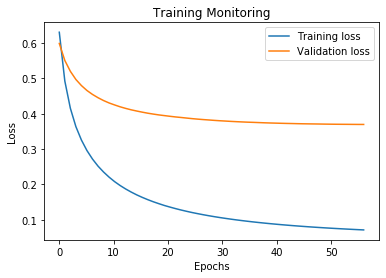

In [44]:
x = np.linspace(0,len(trl),len(trl))
y1, y2 = trl, devl
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Compute accuracy, precision, recall and F1-scores:

In [45]:
p_class_tfidf = predict_class(X = X_test_tfidf, weights = w_tfidf)
Y_te = test_label
preds_te_tfidf = p_class_tfidf

print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.8675
Precision: 0.855072463768116
Recall: 0.885
F1-Score: 0.8697788697788698


Print top-10 most positive and negative words:

In [46]:
dic_tfidf = {}
for i,weight in enumerate(w_tfidf):
    dic_tfidf[vocab[i]] = weight

# get positive words
dic_tfidf_p = {k:v for k, v in dic_tfidf.items() if v>=0}
#order by weights
dic_tfidf_p= dict(sorted(dic_tfidf_p.items(), key=lambda x:x[1], reverse=True))
# select top 10 words
dic_tfidf_p = {k: dic_tfidf_p[k] for k in list(dic_tfidf_p.keys())[:10]}

# get negative words
dic_tfidf_n = {k:v for k, v in dic_tfidf.items() if v<0}
#order by weights
dic_tfidf_n= dict(sorted(dic_tfidf_n.items(), key=lambda x:x[1], reverse=False))
# select top 10 words
dic_tfidf_n = {k: dic_tfidf_n[k] for k in list(dic_tfidf_n.keys())[:10]}

print("The top 10 positive words are %s respectively."% list(dic_tfidf_p.keys()))
print("The top 10 negative words are %s respectively."% list(dic_tfidf_n.keys()))


The top 10 positive words are ['great', 'hilarious', 'fun', 'overall', 'terrific', 'perfectly', 'definitely', 'memorable', 'simple', 'seen'] respectively.
The top 10 negative words are ['bad', 'worst', 'boring', 'supposed', 'unfortunately', 'waste', 'awful', 'poor', 'script', 'nothing'] respectively.


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

#### Answer:
We could use the classifier into a different domain such laptop reviews or restaurant reviews, because there are many adjectives and adverbs that can indicate positive or negative categories, such as 'great', 'hilarious', 'perfectly', etc. for positive features, 'bad', 'boring', 'unfortunately', etc. for negative features, these features would generalise well, so it's suitable in new fields.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

In [48]:
# choose model hyperparameters: learning rate and regularisation strength
lr_hyper = [0.001,0.0001,0.00001]
alpha_hyper = [0.01,0.001,0.0001]

for lr in range(len(lr_hyper)):
    for alpha in range(len(alpha_hyper)):
        w_tfidf, trl, devl = SGD(X_tr = X_tr_tfidf, Y_tr = train_label, 
                                             X_dev=X_dev_tfidf, 
                                             Y_dev=dev_label, 
                                             lr=lr_hyper[lr],
                                             alpha=alpha_hyper[alpha], 
                                             epochs=100)
        preds = predict_class(X = X_test_tfidf, weights = w_tfidf)
        # If test this, we need change `SGD` to comment out that print(add # in front of print, do not print loss), 
        #then we can just see the results of F1-Score for several hyperparameters.
        print('When lr = %f, alpha = %f; '%(lr_hyper[lr],alpha_hyper[alpha]), 'F1-Score:', f1_score(Y_te = test_label, preds_te_count = preds))
        

        

When lr = 0.001000, alpha = 0.010000;  F1-Score: 0.8627450980392156
When lr = 0.001000, alpha = 0.001000;  F1-Score: 0.8627450980392156
When lr = 0.001000, alpha = 0.000100;  F1-Score: 0.8627450980392156
When lr = 0.000100, alpha = 0.010000;  F1-Score: 0.8697788697788698
When lr = 0.000100, alpha = 0.001000;  F1-Score: 0.8669950738916256
When lr = 0.000100, alpha = 0.000100;  F1-Score: 0.8641975308641976
When lr = 0.000010, alpha = 0.010000;  F1-Score: 0.8669950738916256
When lr = 0.000010, alpha = 0.001000;  F1-Score: 0.8669950738916256
When lr = 0.000010, alpha = 0.000100;  F1-Score: 0.8669950738916256


From the above results, we can see that when lr = 0.00001, the F1-Score value is the maximum, 0.8669, in this case, the value of alpha have no effect on the F1-Score value.

In general, the learning rate(lr) has a greater impact on model training, while regularisation strength(alpha) has little effect.

When training the model, if the learning rate is reduced, the gradient descent rate will be slower and the model's convergence rate will also be slower, so in general, the number of training epochs required should  be increased to achieve the purpose of sufficient model convergence.

Regularization can always improve generalization and help prevent overfitting.



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.827 | 0.840 | 0.833 |
| BOW-tfidf  | 0.855 | 0.885 |  0.869 |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [50]:
# load the training, development and test sets
data_tr = pd.read_csv('data_topic/train.csv',header=None, names=['label','text'])
data_dev = pd.read_csv('data_topic/dev.csv',header=None, names=['label','text'])
data_test = pd.read_csv('data_topic/test.csv',header=None, names=['label','text'])

In [51]:
data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [52]:
# put the raw texts into Python lists
train_text = [x.lower() for x in data_tr['text'].tolist()] 
dev_text = [x.lower() for x in data_dev['text'].tolist()] 
test_text = [x.lower() for x in data_test['text'].tolist()]

# put their corresponding labels into NumPy arrays
train_label = np.array(data_tr['label'])
dev_label = np.array(data_dev['label'])
test_label = np.array(data_test['label'])

###  N-gram extraction from the above document

In [53]:
tr_x_mul, tr_text_ngrams_mul = extract_ngrams(x_raw = train_text, stop_words=stop_words)
dev_x_mul, dev_text_ngrams_mul = extract_ngrams(x_raw = dev_text, stop_words=stop_words)
test_x_mul, test_text_ngrams_mul = extract_ngrams(x_raw = test_text, stop_words=stop_words)

Now using `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [54]:
vocab_mul, tr_df_mul, tr_ngram_counts_mul = get_vocab(X_raw=train_text, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

#### Count vectors

In [55]:
X_tr_count_mul = vectorise(X_ngram=tr_text_ngrams_mul, vocab=vocab_mul)
X_dev_count_mul = vectorise(X_ngram=dev_text_ngrams_mul, vocab=vocab_mul)
X_test_count_mul = vectorise(X_ngram=test_text_ngrams_mul, vocab=vocab_mul)

In [56]:
X_tr_count_mul

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [2., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
X_tr_count_mul.shape

(2400, 5000)

In [58]:
X_dev_count_mul.shape

(150, 5000)

#### TF.IDF vectors

In [59]:
# get idf vocabulary dictiongnary for training data
vocab_idfs_tr_mul={}
for word in vocab_mul:
    doc_count=0
    for text in tr_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_tr_mul[word]=np.log((len(tr_text_ngrams_mul)/doc_count))

In [60]:
# get idf vocabulary dictiongnary for development data
vocab_idfs_dev_mul={}
for word in vocab_mul:
    doc_count=0
    for text in dev_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_dev_mul[word]=np.log((len(dev_text_ngrams_mul)+1) / (doc_count+1))

In [61]:
# get idf vocabulary dictiongnary for test data
vocab_idfs_test_mul={}
for word in vocab_mul:
    doc_count=0
    for text in test_text_ngrams_mul:
        if word in text:
            doc_count+=1
    vocab_idfs_test_mul[word]=np.log((len(test_text_ngrams_mul)+1) / (doc_count+1))

In [62]:
# For training set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_tr_mul.keys()):
    value = X_tr_count_mul[:,i]
    tfidf = value * vocab_idfs_tr_mul[word]
    tfidf_mat.append(tfidf)

X_tr_tfidf_mul = np.asarray(tfidf_mat)
X_tr_tfidf_mul = np.transpose(X_tr_tfidf_mul)

In [63]:
X_tr_tfidf_mul

array([[1.33591815, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.33591815, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.33591815, 1.71479843, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.67183631, 1.71479843, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [64]:
# For development set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_dev_mul.keys()):
    value = X_dev_count_mul[:,i]
    tfidf = value * vocab_idfs_dev_mul[word]
    tfidf_mat.append(tfidf)

X_dev_tfidf_mul = np.asarray(tfidf_mat)
X_dev_tfidf_mul = np.transpose(X_dev_tfidf_mul)

In [65]:
# For test set, extract tf.idf vectors
tfidf_mat=[]
for i, word in enumerate(vocab_idfs_test_mul.keys()):
    value = X_test_count_mul[:,i]
    tfidf = value * vocab_idfs_test_mul[word]
    tfidf_mat.append(tfidf)

X_test_tfidf_mul = np.asarray(tfidf_mat)
X_test_tfidf_mul = np.transpose(X_test_tfidf_mul)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [66]:
def softmax(z):
    x_exp = np.exp(z)
    # If it is a one-dimensional array, then axis = 0, otherwise, axis = 1.
    if len(z.shape) >1:
        x_sum = np.sum(x_exp, axis = 1, keepdims = True)
    else:
        x_sum = np.sum(x_exp, axis = 0)
    smax = x_exp / x_sum    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [67]:
def predict_proba(X, weights):
    
    dot_p = np.dot(X,weights.T)
    preds_proba = softmax(dot_p)
    
    return preds_proba

In [68]:
def predict_class(X, weights):
    
    proba = predict_proba(X = X, weights = weights)
    if len(proba.shape) >1:
        label_list = []
        for row in proba:
            row[row == max(row)] = 1
            for i,value in enumerate(row):
                if value == 1:
                    label = i+1
                    label_list.append(label)
                    break;
        preds_class = np.asarray(label_list)
    else:
        proba[proba == max(proba)] = 1
        for i,value in enumerate(proba):
            if value == 1:
                preds_class = i+1
                break;
    
    return preds_class

Toy example and expected functionality of the functions above:

In [69]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [70]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [71]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [72]:
def categorical_loss(X, Y, weights, num_classes=3, alpha=0.00001):
    
    y_pred = predict_proba(X = X, weights = weights)
    #Clip y_pred between alpha and 1-alpha
    y_pred = np.clip(y_pred, alpha, 1-alpha)
    # If there are more than one document for input X
    if len(X.shape) > 1:
        loss = -np.log(y_pred[range(len(Y)),Y-1])
    else:
        loss = -np.log(y_pred[Y-1])
    # Use L2 regularisation
    L2_regularization = (alpha/2)*(np.sum(np.square(weights)))
    l = loss + L2_regularization
    
    return l
    

Convert vector to onehot form

In [73]:
def onehot(X,class_nums):
    
    array = np.eye(class_nums+1)[X]
    
    return np.delete(array,0,axis=1)

Finally you need to modify SGD to support the categorical cross entropy loss:

In [88]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=3, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    pre_loss_dev = 10.
    training_loss_history = []
    validation_loss_history = []
    
    weights = np.zeros((3, X_tr.shape[1]))
    #convert train set label Y_tr to onehot
    Y_tr_onehot = onehot(X = Y_tr,class_nums = num_classes)
    
    #Perform multiple epochs over the training data 
    for i in range(epochs):
        #Randomise the order of training data after each epoch
        np.random.seed(i)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(i)
        new_Y_tr = np.random.permutation(Y_tr)
        np.random.seed(i)
        new_Y_tr_onehot = np.random.permutation(Y_tr_onehot)
        tr_loss_list = [] # The list store training loss for each document.
        for j, X_tr_row in enumerate(new_X_tr):
            tr_loss = categorical_loss(X = X_tr_row, Y=new_Y_tr[j], weights = weights, alpha=alpha)
            tr_loss_list.append(tr_loss)
            y_pred = predict_proba(X = X_tr_row, weights = weights)
            error = y_pred - new_Y_tr_onehot[j]
            #upgrade weights
            weights_list = []
            for n in range(num_classes):
                weights_row = weights[n] - lr*X_tr_row*error[n]
                weights_list.append(weights_row)
            weights = np.asarray(weights_list)
            
        #get average training loss
        aver_tr_loss = np.mean(tr_loss_list)
        training_loss_history.append(aver_tr_loss)
        
        #compute validation set loss
        valid_loss = categorical_loss(X = X_dev, Y=Y_dev, weights = weights, alpha=alpha)
        valid_loss = sum(valid_loss)/len(valid_loss)
        validation_loss_history.append(valid_loss)
        
        #After each epoch print the training and development loss
        print('Epoch: %d' % i, '| Training loss: %f' % aver_tr_loss, '| Validation loss: %f' % valid_loss)
        
        #Stop training if the difference between the current and previous validation loss is smaller than tolerance
        if (pre_loss_dev-valid_loss)<tolerance:
            break
        pre_loss_dev = valid_loss

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [75]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count_mul, Y_tr = train_label, 
                                             X_dev=X_dev_count_mul, 
                                             Y_dev=dev_label,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             epochs=150)

Epoch: 0 | Training loss: 0.990924 | Validation loss: 0.978116
Epoch: 1 | Training loss: 0.840919 | Validation loss: 0.896250
Epoch: 2 | Training loss: 0.748140 | Validation loss: 0.834814
Epoch: 3 | Training loss: 0.682860 | Validation loss: 0.786755
Epoch: 4 | Training loss: 0.633647 | Validation loss: 0.748075
Epoch: 5 | Training loss: 0.594811 | Validation loss: 0.716139
Epoch: 6 | Training loss: 0.563061 | Validation loss: 0.689248
Epoch: 7 | Training loss: 0.536481 | Validation loss: 0.666249
Epoch: 8 | Training loss: 0.513770 | Validation loss: 0.646323
Epoch: 9 | Training loss: 0.494028 | Validation loss: 0.628842
Epoch: 10 | Training loss: 0.476689 | Validation loss: 0.613415
Epoch: 11 | Training loss: 0.461262 | Validation loss: 0.599666
Epoch: 12 | Training loss: 0.447425 | Validation loss: 0.587299
Epoch: 13 | Training loss: 0.434920 | Validation loss: 0.576119
Epoch: 14 | Training loss: 0.423530 | Validation loss: 0.565949
Epoch: 15 | Training loss: 0.413118 | Validation l

##### Plot training and validation process and explain if your model overfit, underfit or is about right:

Answer:
The model is overfit, because the final loss function value of the training data is much lower than that of the validation data. The reason for this result is over-training the training set data, resulting in local optimization, and the model's generalization ability is not good, so the error rate of the verification set is higher than the training set.

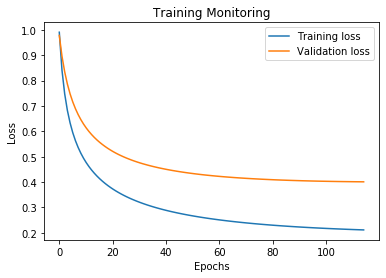

In [76]:
x = np.linspace(0,len(loss_tr_count),len(loss_tr_count))
y1, y2 = loss_tr_count, dev_loss_count
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

##### Compute accuracy, precision, recall and F1-scores:

In [77]:
p_class_count = predict_class(X = X_test_count_mul, weights = w_count)
Y_te = test_label
preds_te_count = p_class_count

print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.8644444444444445
Precision: 0.819078947368421
Recall: 0.83
F1-Score: 0.8245033112582781


##### Print the top-10 words for each class respectively.

In [78]:
for i in range(w_count.shape[0]):
    
    dic_count = {}
    for j,weight in enumerate(w_count[i]):
        dic_count[vocab_mul[j]] = weight

    #order by weights
    dic_count_class= dict(sorted(dic_count.items(), key=lambda x:x[1], reverse=True))
    # select top 10 words
    dic_count_class = {k: dic_count_class[k] for k in list(dic_count_class.keys())[:10]}

    print("The top 10 words for class %d are %s respectively."% (i+1, list(dic_count_class.keys())))
    

The top 10 words for class 1 are ['afp', ('athens', 'greece'), 'najaf', 'murder', 'leader', 'monday', 'president', 'minister', 'said', 'troops'] respectively.
The top 10 words for class 2 are ['athens', 'ap', 'team', ('athens', 'reuters'), 'season', 'olympic', 'game', 'coach', 'players', 'win'] respectively.
The top 10 words for class 3 are ['company', 'business', 'inc', 'corp', 'market', 'oil', 'million', 'billion', 'based', 'bank'] respectively.


##### If we were to apply the classifier we've learned into a different domain, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Answer:

We could not use the classifier into a different domain, because the extracted feature words are basically nouns, these features are only available in a certain field. For example, the words 'murder', 'leader', etc. only apply to International issues, not to the field of Sports. 

So I think these features would not generalise well. And maybe for some adjective or adverb features, the classifier could pick up as important in the new domain.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? 

In [80]:
# choose model hyperparameters: learning rate and regularisation strength
lr_hyper = [0.01,0.001,0.0001]
alpha_hyper = [0.1,0.01,0.001]

for lr in range(len(lr_hyper)):
    for alpha in range(len(alpha_hyper)):
        w_count, loss_tr_count, dev_loss_count = SGD(X_tr = X_tr_count_mul, Y_tr = train_label, 
                                             X_dev=X_dev_count_mul, 
                                             Y_dev=dev_label, 
                                             lr=lr_hyper[lr],
                                             alpha=alpha_hyper[alpha], 
                                             epochs=100)
        preds = predict_class(X = X_test_count_mul, weights = w_count)
        # If test this, we need change `SGD` to comment out that print(add # in front of print, do not print loss), 
        #then we can just see the results of F1-Score for several hyperparameters.
        print('When lr = %f, alpha = %f; '%(lr_hyper[lr],alpha_hyper[alpha]), 'F1-Score:', f1_score(Y_te = test_label, preds_te_count = preds))
        


When lr = 0.010000, alpha = 0.100000;  F1-Score: 0.8225538971807628
When lr = 0.010000, alpha = 0.010000;  F1-Score: 0.83
When lr = 0.010000, alpha = 0.001000;  F1-Score: 0.8250825082508251
When lr = 0.001000, alpha = 0.100000;  F1-Score: 0.8047138047138047
When lr = 0.001000, alpha = 0.010000;  F1-Score: 0.8305647840531561
When lr = 0.001000, alpha = 0.001000;  F1-Score: 0.8239202657807309
When lr = 0.000100, alpha = 0.100000;  F1-Score: 0.8109028960817717
When lr = 0.000100, alpha = 0.010000;  F1-Score: 0.8113522537562604
When lr = 0.000100, alpha = 0.001000;  F1-Score: 0.8113522537562604


From the above results, we can see that when lr = 0.001 and alpha = 0.01, the F1-Score value reaches the maximum, 0.83. As lr or alpha continues to increase, the F1-Score value becomes smaller. 

In general, the learning rate(lr) has a greater impact on model training, and regularisation strength(alpha) also has a certain degree of effect.

### Now evaluate BOW-tfidf...

In [82]:
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr = X_tr_tfidf_mul, Y_tr = train_label, 
                                             X_dev=X_dev_tfidf_mul, 
                                             Y_dev=dev_label,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.01, 
                                             epochs=100)

Epoch: 0 | Training loss: 0.958627 | Validation loss: 0.956724
Epoch: 1 | Training loss: 0.760124 | Validation loss: 0.867729
Epoch: 2 | Training loss: 0.646550 | Validation loss: 0.804482
Epoch: 3 | Training loss: 0.571555 | Validation loss: 0.756887
Epoch: 4 | Training loss: 0.517588 | Validation loss: 0.719420
Epoch: 5 | Training loss: 0.476471 | Validation loss: 0.689058
Epoch: 6 | Training loss: 0.443746 | Validation loss: 0.663801
Epoch: 7 | Training loss: 0.416990 | Validation loss: 0.642392
Epoch: 8 | Training loss: 0.394506 | Validation loss: 0.623917
Epoch: 9 | Training loss: 0.375315 | Validation loss: 0.607820
Epoch: 10 | Training loss: 0.358660 | Validation loss: 0.593657
Epoch: 11 | Training loss: 0.344057 | Validation loss: 0.581029
Epoch: 12 | Training loss: 0.331089 | Validation loss: 0.569718
Epoch: 13 | Training loss: 0.319513 | Validation loss: 0.559480
Epoch: 14 | Training loss: 0.309059 | Validation loss: 0.550186
Epoch: 15 | Training loss: 0.299596 | Validation l

##### Plot training and validation process and explain if your model overfit, underfit or is about right:

The model is overfit, because the final loss function value of the training data is much lower than that of the validation data. The reason for this result is over-training the training set data, resulting in local optimization, and the model's generalization ability is not good, so the error rate of the verification set is higher than the training set.

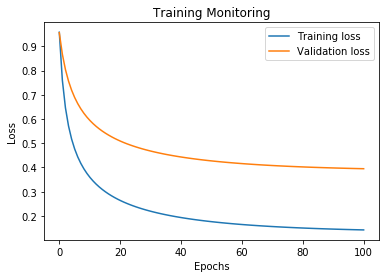

In [83]:
x = np.linspace(0,len(loss_tr_tfidf),len(loss_tr_tfidf))
y1, y2 = loss_tr_tfidf, dev_loss_tfidf
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

##### Compute accuracy, precision, recall and F1-scores:

In [84]:
p_class_tfidf = predict_class(X = X_test_tfidf_mul, weights = w_tfidf)
Y_te = test_label
preds_te_tfidf = p_class_tfidf

print('Accuracy:', accuracy_score(Y_te,preds_te_tfidf))
print('Precision:', precision_score(Y_te,preds_te_tfidf))
print('Recall:', recall_score(Y_te,preds_te_tfidf))
print('F1-Score:', f1_score(Y_te,preds_te_tfidf))

Accuracy: 0.8822222222222222
Precision: 0.8471760797342193
Recall: 0.85
F1-Score: 0.848585690515807


##### Print the top-10 words for each class respectively.

In [85]:
for i in range(w_tfidf.shape[0]):
    
    dic_tfidf = {}
    for j,weight in enumerate(w_tfidf[i]):
        dic_tfidf[vocab_mul[j]] = weight

    #order by weights
    dic_tfidf_class= dict(sorted(dic_tfidf.items(), key=lambda x:x[1], reverse=True))
    # select top 10 words
    dic_tfidf_class = {k: dic_tfidf_class[k] for k in list(dic_tfidf_class.keys())[:10]}

    print("The top 10 words for class %d are %s respectively."% (i+1, list(dic_tfidf_class.keys())))
    

The top 10 words for class 1 are ['afp', ('athens', 'greece'), 'said', 'murder', 'leader', 'beijing', 'najaf', 'president', 'monday', 'india'] respectively.
The top 10 words for class 2 are ['athens', 'ap', 'team', 'olympic', ('athens', 'reuters'), 'season', 'game', 'games', 'coach', 'players'] respectively.
The top 10 words for class 3 are ['company', 'business', 'market', 'oil', 'inc', 'corp', 'based', 'google', 'billion', 'million'] respectively.


##### If we were to apply the classifier we've learned into a different domain, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

Answer:

We could not use the classifier into a different domain, because the extracted feature words are basically nouns, these features are only available in a certain field. For example, the words 'murder', 'leader', etc. only apply to International issues, not to the field of Sports.

So I think these features would not generalise well. And maybe for some adjective or adverb features, the classifier could pick up as important in the new domain.

### Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?

In [87]:
# choose model hyperparameters: learning rate and regularisation strength
lr_hyper = [0.01,0.001,0.0001]
alpha_hyper = [0.1,0.01,0.001]

for lr in range(len(lr_hyper)):
    for alpha in range(len(alpha_hyper)):
        w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD(X_tr = X_tr_tfidf_mul, Y_tr = train_label, 
                                             X_dev=X_dev_tfidf_mul, 
                                             Y_dev=dev_label, 
                                             lr=lr_hyper[lr],
                                             alpha=alpha_hyper[alpha], 
                                             epochs=100)
        preds = predict_class(X = X_test_tfidf_mul, weights = w_tfidf)
        # If test this, we need change `SGD` to comment out that print(add # in front of print, do not print loss), 
        #then we can just see the results of F1-Score for several hyperparameters.
        print('When lr = %f, alpha = %f; '%(lr_hyper[lr],alpha_hyper[alpha]), 'F1-Score:', f1_score(Y_te = test_label, preds_te_count = preds))
        


When lr = 0.010000, alpha = 0.100000;  F1-Score: 0.8189233278955953
When lr = 0.010000, alpha = 0.010000;  F1-Score: 0.8189233278955953
When lr = 0.010000, alpha = 0.001000;  F1-Score: 0.8110749185667753
When lr = 0.001000, alpha = 0.100000;  F1-Score: 0.8504983388704319
When lr = 0.001000, alpha = 0.010000;  F1-Score: 0.8452579034941764
When lr = 0.001000, alpha = 0.001000;  F1-Score: 0.8333333333333334
When lr = 0.000100, alpha = 0.100000;  F1-Score: 0.8504983388704319
When lr = 0.000100, alpha = 0.010000;  F1-Score: 0.848585690515807
When lr = 0.000100, alpha = 0.001000;  F1-Score: 0.848585690515807


From the above results, we can see that when lr = 0.001(or 0.0001) and alpha = 0.1, the F1-Score value reaches the maximum, 0.85. As alpha continues to increase, the F1-Score value becomes smaller. 

In general, the learning rate(lr) has a greater impact on model training, and regularisation strength(alpha) also has a certain degree of effect.

When training the model, if the learning rate is reduced, the gradient descent rate will be slower and the model's convergence rate will also be slower, so in general, the number of training epochs required should be increased to achieve the purpose of sufficient model convergence.

Regularization can always improve generalization and help prevent overfitting.


## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.819 | 0.830 | 0.824 |
| BOW-tfidf  | 0.847 | 0.850 | 0.848 |
